In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
# Path is correct for the YasserH dataset on Kaggle
DATA_PATH = '/kaggle/input/titanic-dataset/Titanic-Dataset.csv'

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print("Column list:", df.columns.tolist(), '\n')
print("Missing values per column:\n", df.isnull().sum(), '\n')

df.info()


Column list: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'] 

Missing values per column:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null

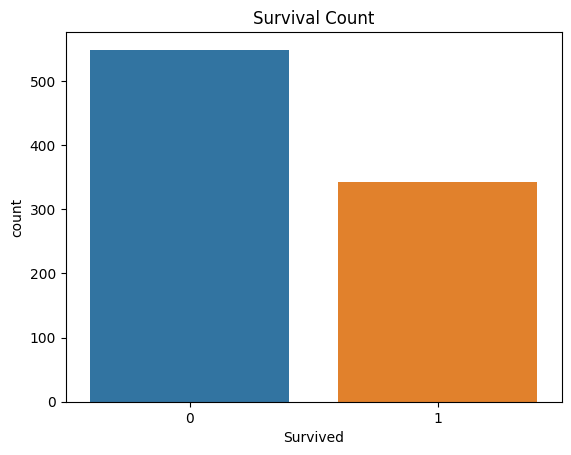

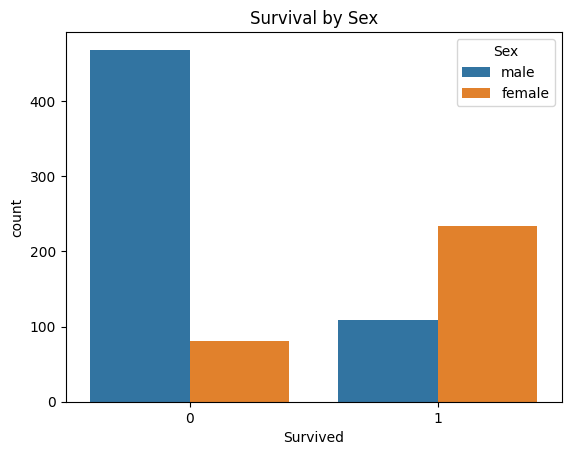

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


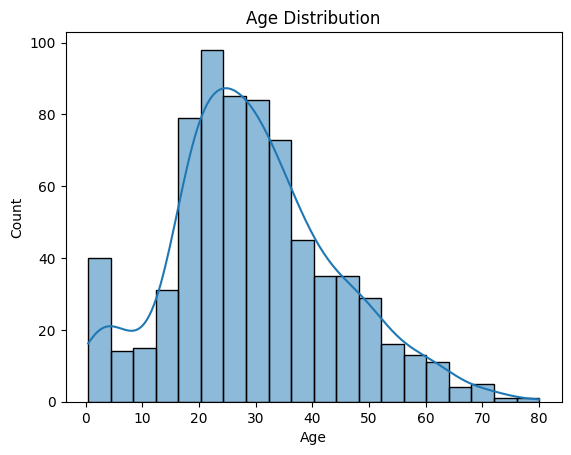

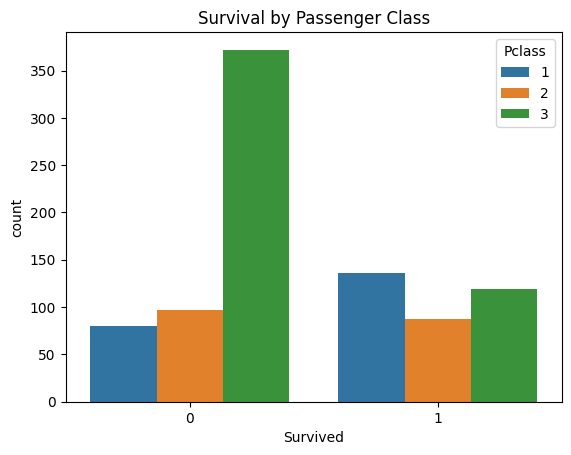

In [4]:
sns.countplot(x='Survived', data=df)
plt.title('Survival Count')
plt.show()

sns.countplot(x='Survived', hue='Sex', data=df)
plt.title('Survival by Sex')
plt.show()

sns.histplot(df['Age'].dropna(), kde=True)
plt.title('Age Distribution')
plt.show()

sns.countplot(x='Survived', hue='Pclass', data=df)
plt.title('Survival by Passenger Class')
plt.show()


In [5]:
# 1️⃣  Drop unused columns *only if they exist*
cols_to_drop = ['Cabin', 'Ticket', 'Name', 'PassengerId']
df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)

# 2️⃣  Handle missing AGE
if df['Age'].isna().any():
    df['Age'] = df['Age'].fillna(df['Age'].median())

# 3️⃣  Handle missing EMBARKED
if 'Embarked' in df.columns:
    if df['Embarked'].isna().any():
        mode_val = df['Embarked'].mode()
        df['Embarked'] = df['Embarked'].fillna(mode_val.iloc[0] if not mode_val.empty else 'S')

# 4️⃣  Encode categorical variables
df['Sex']      = df['Sex'].map({'male': 0, 'female': 1})
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# 5️⃣  Final safety net – fill any residual NaN numerics with column median
df = df.fillna(df.median(numeric_only=True))

# 6️⃣  Confirm zero missing values
print("🔍 Remaining NaNs after cleaning:\n", df.isnull().sum())


🔍 Remaining NaNs after cleaning:
 Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [6]:
X = df.drop('Survived', axis=1)
y = df['Survived']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling helps LR but isn’t mandatory; add if you like
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [8]:
# Use liblinear solver for small datasets
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000, solver='liblinear')

In [9]:
y_pred = model.predict(X_test_scaled)

print("✅ Accuracy :", accuracy_score(y_test, y_pred).round(4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))


✅ Accuracy : 0.8045

Confusion Matrix:
 [[98 12]
 [23 46]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8099    0.8909    0.8485       110
           1     0.7931    0.6667    0.7244        69

    accuracy                         0.8045       179
   macro avg     0.8015    0.7788    0.7864       179
weighted avg     0.8034    0.8045    0.8007       179



In [10]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coeff'  : model.coef_[0]
}).sort_values('Coeff', ascending=False)

importance


,Feature,Coeff
1,Sex,1.268171
6,Embarked,0.220601
5,Fare,0.102920
4,Parch,-0.067766
3,SibSp,-0.262263
2,Age,-0.502872
0,Pclass,-0.930603


# ✅ Final Summary

This Titanic survival prediction project was completed as part of my Data Science Internship. Here's a quick overview of the key points:

### 🔍 Model Used:
- Logistic Regression (baseline ML model for binary classification)
- Scaled features using `StandardScaler`

### 📊 Evaluation:
- Accuracy: _(0.805)_
- Model performs well for identifying survival trends based on features like Sex, Pclass, Age, etc.

### 📌 Key Learnings:
- Data preprocessing and encoding are **critical**
- Logistic regression works well as a **first ML model**
- Handling missing data correctly avoids training errors
- Simple visualizations give strong insights


Thanks to [Kaggle Datasets](https://www.kaggle.com/datasets/yasserh/titanic-dataset) for making this available for learners.

